In [3]:
import os
import scanpy as sc
import pandas as pd
import cellxgene_census
from sklearn.metrics import normalized_mutual_info_score
import matplotlib.pyplot as plt
import umap.umap_ as umap

import anndata as ad
import cellxgene_census

In [9]:
import igraph as ig
import leidenalg as la

In [12]:
 metadata = pd.read_csv('/projects/bioinformatics/DB/scRNAseq_parkinson/metadata.csv')

In [2]:
# Load embedding
df_scvi = pd.read_csv(
    "/projects/bioinformatics/DB/scRNAseq_parkinson/scvi_embedding.csv",
    index_col=0
)

/home/znazari/cellxgene_census2025_new/lib/python3.12/site-packages/anndata/_core/anndata.py:812: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")


In [30]:
# Step 1: create AnnData
adata = ad.AnnData(df_scvi.values)

# Step 2: optionally give obs_names
adata.obs_names = df_scvi.index.astype(str)  # or just leave them as 0,1,2...

# Step 3: assign metadata by position
adata.obs["disease"] = metadata["disease"].values
adata.obs["cell_type"] = metadata["cell_type"].values

# Step 4: combined label
adata.obs["celltype_condition"] = (
    adata.obs["cell_type"].astype(str) + "_" + adata.obs["disease"].astype(str)
)

# Step 5: check
#adata.obs.head()
adata.obs.isna().mean()


disease               0.0
cell_type             0.0
celltype_condition    0.0
dtype: float64

In [31]:
adata.obs

,disease,cell_type,celltype_condition
0,Parkinson disease,oligodendrocyte,oligodendrocyte_Parkinson disease
1,Parkinson disease,oligodendrocyte,oligodendrocyte_Parkinson disease
2,Parkinson disease,oligodendrocyte,oligodendrocyte_Parkinson disease
3,Parkinson disease,oligodendrocyte,oligodendrocyte_Parkinson disease
4,Parkinson disease,astrocyte,astrocyte_Parkinson disease
...,...,...,...
2096150,normal,oligodendrocyte,oligodendrocyte_normal
2096151,Parkinson disease,glutamatergic neuron,glutamatergic neuron_Parkinson disease
2096152,Parkinson disease,central nervous system macrophage,central nervous system macrophage_Parkinson di...
2096153,normal,oligodendrocyte precursor cell,oligodendrocyte precursor cell_normal


In [32]:
# Compute neighbors
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X')

# Save AnnData with neighbors embedded
adata.write("adata_with_neighbors.h5ad")


In [33]:
adata = sc.read("adata_with_neighbors.h5ad")

In [34]:
# Smart function to compute NMI
def compute_nmi_table(adata, resolutions, label_keys):
    results = []

    for res in resolutions:
        key = f"leiden_r{res}"
        sc.tl.leiden(adata, resolution=res, key_added=key, random_state=0)

        for label in label_keys:
            valid = adata.obs[[key, label]].dropna()

            nmi = normalized_mutual_info_score(
                valid[key].astype(str),
                valid[label].astype(str)
            )

            results.append({
                "resolution": res,
                "label": label,
                "NMI": nmi
            })

    return pd.DataFrame(results)

In [35]:
# Run
resolutions = [0.3, 0.5, 0.8, 1.0]

labels_to_test = [
    "cell_type",
    "disease",
    "celltype_condition"
]

nmi_results = compute_nmi_table(
    adata,
    resolutions=resolutions,
    label_keys=labels_to_test
)

print(nmi_results)

/var/tmp/pbs.406741.pbs01/ipykernel_1024/1968090352.py:7: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=res, key_added=key, random_state=0)


    resolution               label       NMI
0          0.3           cell_type  0.766404
1          0.3             disease  0.002377
2          0.3  celltype_condition  0.678208
3          0.5           cell_type  0.714539
4          0.5             disease  0.004963
5          0.5  celltype_condition  0.639337
6          0.8           cell_type  0.662035
7          0.8             disease  0.004330
8          0.8  celltype_condition  0.597499
9          1.0           cell_type  0.650230
10         1.0             disease  0.004446
11         1.0  celltype_condition  0.588126


In [36]:
# Save everything
nmi_results.to_csv("scvi_nmi_by_resolution.csv", index=False)
adata.write("adata_scvi_leiden_sweep.h5ad")

In [3]:
nmi_result = pd.read_csv("scvi_nmi_by_resolution.csv")

In [5]:
nmi_result

,resolution,label,NMI
0,0.3,cell_type,0.766404
1,0.3,disease,0.002377
2,0.3,celltype_condition,0.678208
3,0.5,cell_type,0.714539
4,0.5,disease,0.004963
5,0.5,celltype_condition,0.639337
6,0.8,cell_type,0.662035
7,0.8,disease,0.004330
8,0.8,celltype_condition,0.597499
9,1.0,cell_type,0.650230


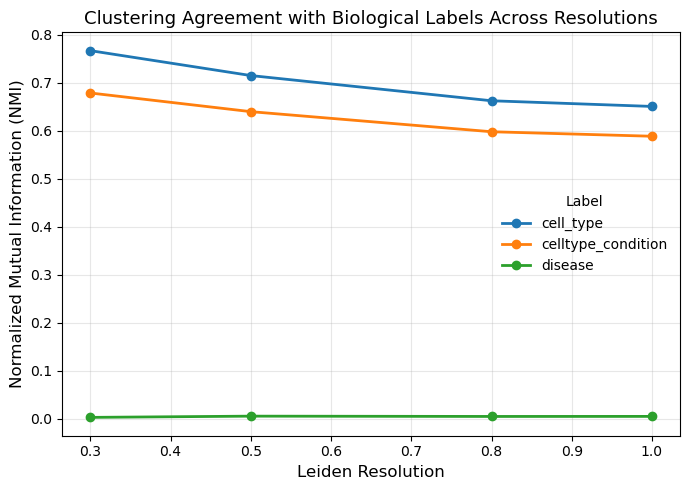

In [4]:
# Pivot for clean plotting
pivot_df = nmi_result.pivot(index="resolution", columns="label", values="NMI")

# Create figure
plt.figure(figsize=(7, 5))

# Plot each label (no explicit colors)
for col in pivot_df.columns:
    plt.plot(
        pivot_df.index,
        pivot_df[col],
        marker="o",
        linewidth=2,
        label=col
    )

# Axis labels
plt.xlabel("Leiden Resolution", fontsize=12)
plt.ylabel("Normalized Mutual Information (NMI)", fontsize=12)

# Title
plt.title("Clustering Agreement with Biological Labels Across Resolutions", fontsize=13)

# Legend
plt.legend(frameon=False, title="Label")

# Grid (subtle, journal style)
plt.grid(alpha=0.3)

# Layout
plt.tight_layout()

plt.show()